In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [2]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [3]:
data = pd.read_csv("all_agree.csv")
data

,title,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,0
...,...,...
17222,We Know Who You Plan On Spending Valentine's D...,1
17223,15 Ridiculously Irresistible Ways To Eat Oreos,1
17224,24 Stages Of Getting Shitfaced During The Week,1
17225,21 Things Only Former Baby Lesbians Understand,1


### Number of characters present in each sentence

<Axes: >

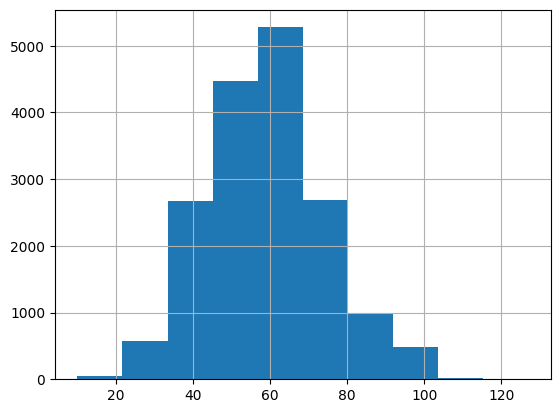

In [4]:
data['title'].str.len().hist()

The histogram shows that news headlines range from 10 to 120 characters and generally, it is between 40 to 80 characters.

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each title.

### Number of Words Appearing in Each Title

<Axes: >

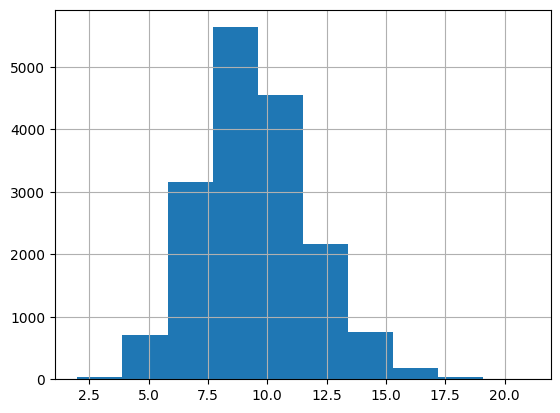

In [5]:
data['title'].str.split().map(lambda x: len(x)).hist()

It is clear that the number of words in the title column ranges from 2 to 17 words and most of them range from 5 to 12 words.

next, let's check the average word length in each sentence.

### Average Word Length

<Axes: >

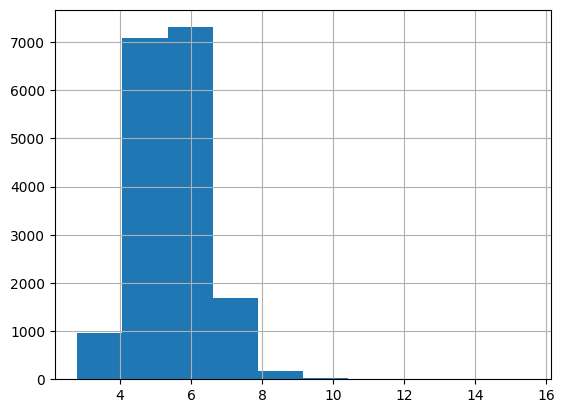

In [6]:
data['title'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

Average word length ranges from 3 to 10 with 6 being the most common word length.

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [8]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length) -> None:
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        sentence = self.preprocess(str(self.df['title'].values[index]))
        label = self.df['label_score'].values[index]
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True,
            return_token_type_ids=False
        )

        return {
            "input_ids": encoding['input_ids'].flatten(),
            "attention_mask": encoding['attention_mask'].flatten(),
            "targets": torch.tensor(label, dtype=torch.long)
        }

    def preprocess(self, sentence):
        return sentence

def create_data_loader(df, tokenizer, max_length, batch_size):
    ds = TextDataset(df, tokenizer, max_length)
    return DataLoader(ds, batch_size=batch_size)

In [9]:
df_train, test = train_test_split(data, test_size=0.2, random_state=40)
train, val = train_test_split(df_train, test_size=0.15, random_state=40)

In [10]:
train_dataloader = create_data_loader(train, tokenizer, 256, 16)
val_dataloader = create_data_loader(val, tokenizer, 256, 16)
test_dataloader = create_data_loader(test, tokenizer, 256, 16)

In [11]:
next(iter(train_dataloader))

{'input_ids': tensor([[  101, 31270, 11178,  ...,     0,     0,     0],
         [  101, 10419, 37399,  ...,     0,     0,     0],
         [  101, 12980, 76322,  ...,     0,     0,     0],
         ...,
         [  101, 42754, 29465,  ...,     0,     0,     0],
         [  101, 10284, 39854,  ...,     0,     0,     0],
         [  101, 12834, 75633,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])}

### Build Model

In [12]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-multilingual-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output[1]
        output = self.dropout(pooled_output)
        logits = self.classifier(output)
        return logits

# model = BertClassifier(num_classes=2)

# for batch in train_dataloader:
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
#     targets = batch['targets']
#     outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#     print(outputs)
#     break

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(num_classes=2)
model = model.to(device)

EPOCH = 10
optimizer = optim.AdamW(
    [
        {'params': model.bert_model.parameters()},
        {'params': model.classifier.parameters(), 'lr': 1e-3}
    ],
    lr=1e-5,
    weight_decay=0.9
)

total_steps = len(train_dataloader) * EPOCH
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

In [14]:
def train_model(model, data_loader, loss_fn, optimizer, scheduler, n_examples):
    model.train()
    losses = []
    pred_list = torch.tensor([], dtype=torch.long).to(device)
    true_list = torch.tensor([], dtype=torch.long).to(device)
    f1_score_list = []

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)

        losses.append(loss.item())

        preds = torch.argmax(outputs, dim=1)
        pred_list = torch.cat((pred_list, preds), dim=0)
        true_list = torch.cat((true_list, targets), dim=0)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    f1 = f1_score(true_list.cpu(), pred_list.cpu(), average='weighted')
    return f1, np.mean(losses)

def eval_model(model, data_loader, loss_fn, n_examples):
    model.eval()
    losses = []
    pred_list = torch.tensor([], dtype=torch.long).to(device)
    true_list = torch.tensor([], dtype=torch.long).to(device)

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)

            losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            pred_list = torch.cat((pred_list, preds), dim=0)
            true_list = torch.cat((true_list, targets), dim=0)

    f1 = f1_score(true_list.cpu(), pred_list.cpu(), average='weighted')
    return f1, np.mean(losses)

In [15]:
history = {
    "train_f1": [],
    "train_loss": [],
    "val_f1": [],
    "val_loss": []
}

best_accuracy = 0

for epoch in range(EPOCH):
    print(f"Epoch {epoch + 1}/{EPOCH}")
    print("-" * 10)

    train_f1, train_loss = train_model(model, train_dataloader, loss_fn, optimizer, scheduler, len(train))
    print(f"Train F1 Score: {train_f1}, Train Loss: {train_loss}")

    val_f1, val_loss = eval_model(model, val_dataloader, loss_fn, len(val))
    print(f"Val F1 Score: {val_f1}, Val Loss: {val_loss}")

    history["train_f1"].append(train_f1)
    history["train_loss"].append(train_loss)
    history["val_f1"].append(val_f1)
    history["val_loss"].append(val_loss)

test_f1, test_loss = eval_model(model, test_dataloader, loss_fn, len(test))
print(f"Test F1 Score: {test_f1}, Test Loss: {test_loss}")

Epoch 1/10
----------
Train F1 Score: 0.9135997372405623, Train Loss: 0.2103019243250455
Val F1 Score: 0.9565018812432105, Val Loss: 0.11278510695466629
Epoch 2/10
----------
Train F1 Score: 0.9629194968102894, Train Loss: 0.09843010859976721
Val F1 Score: 0.954677897859716, Val Loss: 0.15769487538885957
Epoch 3/10
----------
Train F1 Score: 0.9783113459941809, Train Loss: 0.05852733910614295
Val F1 Score: 0.9508449576347948, Val Loss: 0.17283842638266483
Epoch 4/10
----------
Train F1 Score: 0.9882175424854311, Train Loss: 0.03271829247811428
Val F1 Score: 0.9599019398165091, Val Loss: 0.1829603189189199
Epoch 5/10
----------
Train F1 Score: 0.9924016773770201, Train Loss: 0.019887406665148644
Val F1 Score: 0.9594211903395139, Val Loss: 0.24767286191362944
Epoch 6/10
----------
Train F1 Score: 0.9944503450739628, Train Loss: 0.015627646867478227
Val F1 Score: 0.9589259691986007, Val Loss: 0.20880526420173912
Epoch 7/10
----------
Train F1 Score: 0.9967559260245692, Train Loss: 0.00913

In [16]:
test_f1, test_loss = eval_model(model, test_dataloader, loss_fn, len(test))
print(f"Test F1 Score: {test_f1}, Test Loss: {test_loss}")

Test F1 Score: 0.9573151066196811, Test Loss: 0.2785989476228747


In [17]:
import torch.nn.functional as F

In [20]:
def predict(text):
    label_text = ['Negative','Positive']

    encoded = tokenizer.encode_plus(
        text,
        max_length=256,
        padding='max_length',
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
        truncation=True
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    with torch.no_grad():
        out = model(input_ids, attention_mask)
        prob = F.softmax(out, dim=1)
        confidence, predicted_class = torch.max(prob, dim=1)
        predicted_class = predicted_class.item()
        prob = prob.flatten().tolist()
        print(f"Predicted sentiment: {label_text[predicted_class]}")
        print("Confidence:", confidence.item())

In [22]:
text = "Viral! Driver Ojol di Bekasi Antar Pesanan Makanan Pakai Sepeda"
predict(text)

Predicted sentiment: Positive
Confidence: 0.9999998807907104


In [23]:
text = "Obama budget calls for record US deficit"
predict(text)

Predicted sentiment: Negative
Confidence: 1.0
